# ST-HDBSCAN: Spatiotemporal Hierarchical DBSCAN for Trajectory Data

## Abstract

The study of human mobility has advanced greatly in recent years due to the availability of
commercial large-scale GPS trajectory datasets [3]. However, the validity of findings that use
these datasets depends heavily on the robustness of their pre-processing methods. An important
step in the processing of mobility data is the detection of stops within GPS trajectories, for
which many clustering algorithms have been proposed [4, 8, 6, 1]. Yet, the high sparsity of
commercial GPS data can affect the performance of these stop-detection algorithms.
In the case of DBSCAN, while it initially identifies dense regions, it can often over-cluster
or under-cluster due to noise and weakly connected points given the chosen ε. ST-DBSCAN [4]
uses two distance thresholds, Eps1 for spatial and Eps2 for non-spatial values. The algorithm
compares the average non-spatial value, such as temperature, of a cluster with a new com-
ing value, to prevent merging adjacent clusters. Nevertheless, datasets that include this kind
of information are not comparable to realistic GPS-based trajectories. A promising algorithm
is T-DBSCAN [6], which searches forward in time for a continuous density-based neighbor-
hood of core points. Points spatially close, within Eps, and within a roaming threshold, CEps, are included in a cluster. Additionally, we used a time-augmented DBSCAN algorithm, TA-DBSCAN, which recursively processes the clusters obtained from DBSCAN to address the issue of initial clusters overlapping in time. However, methods [9] that validate stop-detection algorithms based on synthetic data show that these can omit, merge, or split stops based on the selection of epsilon and sparsity of the data.

If we define parameters that may be considered fine (low ε), it might completely miss a stop at a larger location. In contrast, coarse parameters (large ε) may struggle to differentiate stops within small neighboring locations [3]. Since different venues vary in stop durations and areas, this could influence the parameter choices [9]. To address this parameter selection limitation, we propose a spatiotemporal variation of Hierarchical DBSCAN [5], ST-HDBSCAN. Unlike DBSCAN, which relies on one threshold of density to cluster points, our variation constructs separate structures for space and time distances that preserve density-based connections in these two dimensions. This approach ensures that when pruning the hierarchical tree structure needed for cluster formation, we account for varying spatiotemporal densities. As a result, clusters emerge naturally without requiring specific time and space thresholds, working effectively across different data sparsity levels.

In [163]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import pandas as pd
import numpy as np
from datetime import timedelta
import pygeohash as gh
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyproj import Transformer
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [165]:
import nomad.io.base as loader
import nomad.constants as constants
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.filters as filters
import nomad.city_gen as cg

In [5]:
traj_cols = {'user_id':'uid',
             'datetime':'local_datetime',
             'latitude':'latitude',
             'longitude':'longitude'}

data = loader.from_file("../../nomad/data/gc_sample.csv")

In [6]:
# We create a time offset column with different UTC offsets (in seconds)
data['tz_offset'] = 0
data.loc[data.index[:5000],'tz_offset'] = -7200
data.loc[data.index[-5000:], 'tz_offset'] = 3600

# create datetime column as a string
data['local_datetime'] = loader._unix_offset_to_str(data.timestamp, data.tz_offset)
data['local_datetime'] = pd.to_datetime(data['local_datetime'], utc=True)

# create x, y columns in web mercator
gdf = gpd.GeoSeries(gpd.points_from_xy(data.longitude, data.latitude),
                        crs="EPSG:4326")
projected = gdf.to_crs("EPSG:3857")
data['x'] = projected.x
data['y'] = projected.y

In [7]:
data

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y
0,wizardly_joliot,1704119340,38.321711,-36.667334,-7200,2024-01-01 14:29:00+00:00,-4.081789e+06,4.624973e+06
1,wizardly_joliot,1704119700,38.321676,-36.667365,-7200,2024-01-01 14:35:00+00:00,-4.081792e+06,4.624968e+06
2,wizardly_joliot,1704155880,38.320959,-36.666748,-7200,2024-01-02 00:38:00+00:00,-4.081724e+06,4.624866e+06
3,wizardly_joliot,1704156000,38.320936,-36.666739,-7200,2024-01-02 00:40:00+00:00,-4.081723e+06,4.624863e+06
4,wizardly_joliot,1704156840,38.320924,-36.666747,-7200,2024-01-02 00:54:00+00:00,-4.081724e+06,4.624861e+06
...,...,...,...,...,...,...,...,...
25830,angry_spence,1705303380,38.320399,-36.667438,3600,2024-01-15 07:23:00+00:00,-4.081801e+06,4.624787e+06
25831,angry_spence,1705303740,38.320413,-36.667469,3600,2024-01-15 07:29:00+00:00,-4.081804e+06,4.624789e+06
25832,angry_spence,1705303980,38.320384,-36.667455,3600,2024-01-15 07:33:00+00:00,-4.081802e+06,4.624785e+06
25833,angry_spence,1705304340,38.320349,-36.667473,3600,2024-01-15 07:39:00+00:00,-4.081804e+06,4.624780e+06


In [8]:
user_sample = data.loc[data.uid == "angry_spence"]
user_sample = user_sample[['timestamp', 'x', 'y']]

In [9]:
user_sample

,timestamp,x,y
24139,1704104460,-4.081702e+06,4.624871e+06
24140,1704104820,-4.081697e+06,4.624867e+06
24141,1704104940,-4.081696e+06,4.624866e+06
24142,1704105540,-4.081698e+06,4.624865e+06
24143,1704105720,-4.081699e+06,4.624866e+06
...,...,...,...
25830,1705303380,-4.081801e+06,4.624787e+06
25831,1705303740,-4.081804e+06,4.624789e+06
25832,1705303980,-4.081802e+06,4.624785e+06
25833,1705304340,-4.081804e+06,4.624780e+06


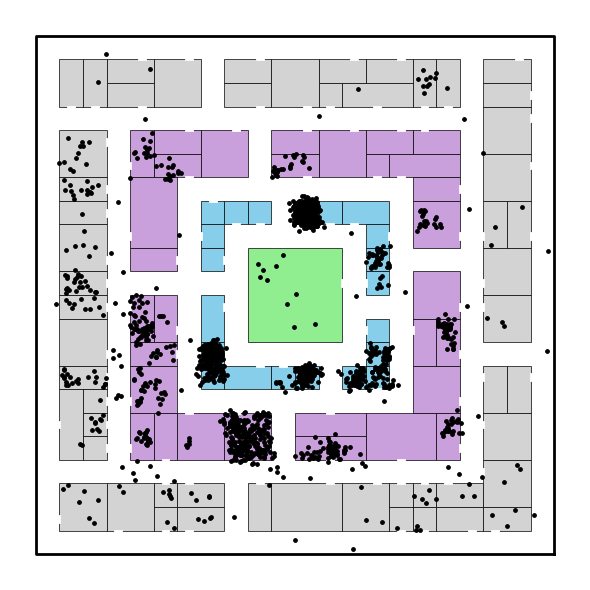

In [10]:
%matplotlib inline

plot_df = data.loc[data.uid == "angry_spence"].copy()
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_df['x'], plot_df['y'] = transformer.transform(plot_df['latitude'].values, plot_df['longitude'].values)
plot_df['x'] = (plot_df['x'] - 4265699)/15
plot_df['y'] = (plot_df['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [11]:
time_pairs = HDBSCAN._find_bursts(user_sample['timestamp'], 14)
core_distances = HDBSCAN._compute_core_distance(user_sample, time_pairs, 4)
mrd = HDBSCAN._compute_mrd_graph(user_sample, core_distances)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = HDBSCAN.mst_ext(mst_edges, core_distances)

In [74]:
# Synthetic dataset with connected 2 components connected by an edge with weight infinity
def synthetic_graph_with_cc():
    # MST edges within cluster A
    edges_a = [(1, 2, 0.15), (2, 3, 0.20)]
    # MST edges within cluster B
    edges_b = [(4, 5, 0.1), (5, 6, 0.19)]
    # Artificial high-weight edge between cluster A and B
    bridge_edge = [(3, 4, np.inf)]

    # Combine into full MST+ext
    mst_ext_df = pd.DataFrame(edges_a + edges_b + bridge_edge, columns=["from", "to", "weight"])

    return mst_ext_df

In [84]:
def synthetic_graph_with_4cc():
    # Cluster A
    edges_a = [(1, 2, 0.1), (2, 3, 0.15)]
    # Cluster B
    edges_b = [(4, 5, 0.1), (5, 6, 0.2)]
    # Cluster C
    edges_c = [(7, 8, 0.05), (8, 9, 0.12)]
    # Cluster D
    edges_d = [(10, 11, 0.08), (11, 12, 0.18)]

    # Bridge edges with high weights
    bridges = [
        (3, 4, np.inf),  # A to B
        (6, 7, 20),  # B to C
        (9, 10, 15)  # C to D
    ]

    all_edges = edges_a + edges_b + edges_c + edges_d + bridges
    mst_ext_df = pd.DataFrame(all_edges, columns=["from", "to", "weight"])

    return mst_ext_df

In [78]:
def visualize_mst(mst_df):
    G = nx.Graph()

    for u, v, w in mst_df.itertuples(index=False):
        w_val = 1e6 if np.isinf(w) else w
        inv_w = 1.0 / w_val if w_val > 0 else 0.001
        label = "∞" if np.isinf(w) else f"{w:.2f}"
        G.add_edge(u, v, weight=w_val, inv_weight=inv_w, label=label)

    # Use inverse weights for layout
    pos = nx.spring_layout(G, weight='inv_weight')

    # Retrieve edge labels from edge attributes
    edge_labels = nx.get_edge_attributes(G, 'label')

    # Plot
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("MST Extended Graph with Edge Weights")
    plt.axis('off')
    plt.show()

def visualize_adjacency_dict(G_dict):
    """
    Visualize an adjacency dictionary as a NetworkX graph.

    Parameters
    ----------
    G_dict : dict
        Output of _build_graph() — {node: set(neighbors)}
    """
    # Convert dict-of-sets into a networkx Graph
    G = nx.Graph()
    for u, neighbors in G_dict.items():
        for v in neighbors:
            G.add_edge(u, v)

    print(G.number_of_nodes())

    pos = nx.spring_layout(G, seed=42)

    # Draw graph
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightgreen',
        edge_color='gray',
        node_size=200,
        font_size=10
    )
    plt.title("Connected Component After Edge Removal")
    plt.tight_layout()
    plt.show()

,from,to,weight
0,1,2,0.10
1,2,3,0.15
2,4,5,0.10
3,5,6,0.20
4,7,8,0.05
5,8,9,0.12
6,10,11,0.08
7,11,12,0.18
8,3,4,inf
9,6,7,20.00


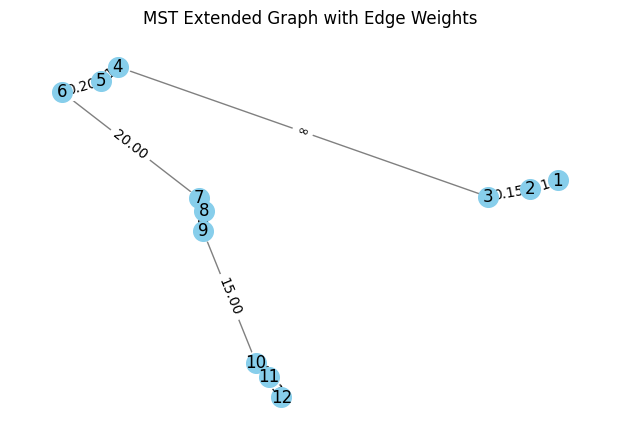

In [186]:
mst_4cc = synthetic_graph_with_4cc()
display(mst_4cc)
visualize_mst(mst_4cc)

,from,to,weight
0,1,2,0.15
1,2,3,0.20
2,4,5,0.10
3,5,6,0.19
4,3,4,inf


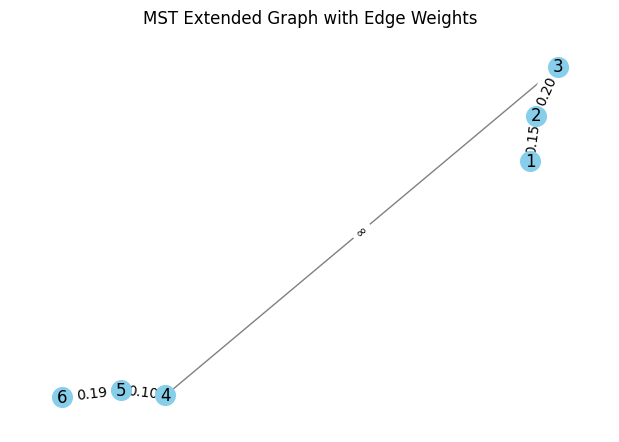

In [109]:
mst_ext_df = synthetic_graph_with_cc()
display(mst_ext_df)
visualize_mst(mst_ext_df)

In [187]:
label_history_df, hierarchy_df = HDBSCAN.hdbscan(mst_4cc, 2)
# display(label_history_df)
display(hierarchy_df)


,child,parent,scale
0,1,0,inf
1,2,0,inf
2,3,2,20.0
3,4,2,20.0
4,5,4,15.0
5,6,4,15.0


In [168]:
def get_eps(label_history_df, target_cluster_id):
    exit_data = []
    
    # ε_max(Ci): maximum ε value at which Ci exisits
    eps_max = label_history_df[label_history_df['cluster_id']== target_cluster_id]['dendrogram_scale'].max()
    timestamps = label_history_df[label_history_df['cluster_id'] == target_cluster_id]['timestamp'].unique()

    for ts in timestamps:
        # print(ts)
        history = label_history_df[label_history_df['timestamp'] == ts].copy()
        # print(history)
        history = history[~history['dendrogram_scale'].isna()]
        history = history.sort_values('dendrogram_scale', ascending=False)
        # print(history)

        in_cluster = history[history['cluster_id'] == target_cluster_id]
        # print("in cluster:")
        # print(in_cluster)
        out_cluster = history[history['cluster_id'] != target_cluster_id]
        # print("out cluster:")
        # print(out_cluster)

        if not in_cluster.empty:
            last_in_cluster_scale = in_cluster['dendrogram_scale'].min()  # since descending
            # print("scale last in cluster", last_in_cluster_scale)
            exited_after = out_cluster[out_cluster['dendrogram_scale'] < last_in_cluster_scale]

            if not exited_after.empty:
                # ε_min(xj , Ci): ε value (scale) beyond which object xj no longer belongs to cluster Ci
                eps_min = exited_after['dendrogram_scale'].max()  # highest scale after exit
            else:
                eps_min = np.inf  # never exited
        else:
            eps_min = np.nan  # never entered

        exit_data.append({
            "timestamp": ts,
            "eps_min": eps_min,
            "eps_max": eps_max
        })

        # print("-----")

    return pd.DataFrame(exit_data)

In [170]:
def compute_cluster_stability(label_history_df):
    # Get clusters that are not root (0) or noise (-1)
    clusters = label_history_df.loc[~label_history_df['cluster_id'].isin([0, -1]), 'cluster_id'].unique()

    cluster_stability_df = []

    for cluster in clusters:
        eps_df = get_eps(label_history_df, target_cluster_id=cluster)
        
        # Avoid division by zero or NaNs
        eps_df = eps_df.replace({'eps_min': {0: np.nan}, 'eps_max': {0: np.nan}})
        eps_df['stability_term'] = 1 / eps_df['eps_min'] - 1 / eps_df['eps_max']
        
        total_stability = eps_df['stability_term'].sum(skipna=True)
        
        cluster_stability_df.append({
            "cluster_id": cluster,
            "cluster_stability": total_stability
        })

    return pd.DataFrame(cluster_stability_df)


In [188]:
cluster_stability_df = compute_cluster_stability(label_history_df)
cluster_stability_df

,cluster_id,cluster_stability
0,1,26.666667
1,2,0.450000
2,3,24.850000
3,4,0.100000
4,5,48.133333
5,6,30.355556


- λ_min(Ci): minimum density level at which Ci exists
    - ε_max(Ci): maximum ε value (scale) at which Ci exisits
- λ_max(xj,Ci): the density level beyond which object xj no longer belongs to cluster Ci
    - ε_min(xj , Ci): ε value (scale) beyond which object xj no longer belongs to cluster Ci

In [209]:
label_history_df[label_history_df['cluster_id'] == 3]

,timestamp,cluster_id,dendrogram_scale
27,4,3,20.00
28,5,3,20.00
29,6,3,20.00
39,4,3,15.00
40,5,3,15.00
41,6,3,15.00
51,4,3,0.20
52,5,3,0.20
63,4,3,0.18
64,5,3,0.18


In [ ]:
def get_cluster_memberships(label_history_df, selected_clusters):
    """
    """
    all_timestamps = set(label_history_df['timestamp'])
    assigned_timestamps = set()
    cluster_members = {}

    for cid in selected_clusters:
        # Filter to rows where cluster_id == cid
        cluster_rows = label_history_df[label_history_df['cluster_id'] == cid]

        if cluster_rows.empty:
            continue  # skip if no rows (just in case)
        
        # Find the smallest scale before this cluster disappears/splits into subclusters
        min_scale = cluster_rows['dendrogram_scale'].min()
        
        # Get the timestamps assigned to this cluster at that scale
        members = set(cluster_rows[cluster_rows['dendrogram_scale'] == min_scale]['timestamp'])
        cluster_members[cid] = members
        assigned_timestamps.update(members)
    
    cluster_members[-1] = all_timestamps - assigned_timestamps

    return cluster_members


In [231]:
selected_cluster_membership = get_cluster_memberships_from_history(label_history_df, [1, 3, 5, 6])
selected_cluster_membership

{1: {1, 2}, 3: {4, 5}, 5: {7, 8}, 6: {10, 11}, -1: {3, 6, 9, 12}}

In [173]:
cluster_stability_df = pd.DataFrame({
    "cluster_id": [2,3,4,5,6,7,8,9,10,11],
    "cluster_stability": [7,5,6,6,2,1,1,1,2,2]
})

hierarchy_df = pd.DataFrame({
    "child": [2,3,4,5,6,7,8,9,10,11],
    "parent": [0,0,2,2,3,3,5,5,8,8],
    "scale": [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]
}) 

In [175]:
hierarchy_df

,child,parent,scale
0,2,0,inf
1,3,0,inf
2,4,2,inf
3,5,2,inf
4,6,3,inf
5,7,3,inf
6,8,5,inf
7,9,5,inf
8,10,8,inf
9,11,8,inf


In [182]:
def select_most_stable_clusters(hierarchy_df, cluster_stability_df):
    hierarchy = [
        (group['scale'].iloc[0], parent, list(group['child']))
        for parent, group in hierarchy_df.groupby('parent')
    ]
    
    # Build tree of clusters
    children = defaultdict(list)
    parent = {}
    for _, parent_id, child_ids in hierarchy:
        for child_id in child_ids:
            children[parent_id].append(child_id)
            parent[child_id] = parent_id

    # Stability lookup
    stability_map = dict(zip(cluster_stability_df['cluster_id'], cluster_stability_df['cluster_stability']))
    
    selected_clusters = set()
    best_stability = {}

    # Get descendants of cluster
    def get_descendants(cid):
        descendants = set()
        stack = [cid]
        while stack:
            node = stack.pop()
            for child in children.get(node, []):
                descendants.add(child)
                stack.append(child)
        return descendants

    # DFS
    def dfs(cid):
        if cid not in children:
            best_stability[cid] = stability_map.get(cid, 0.0)
            selected_clusters.add(cid)
            return best_stability[cid]

        sum_children = sum(dfs(child) for child in children[cid])
        own_stab = stability_map.get(cid, 0.0)

        if own_stab >= sum_children:
            best_stability[cid] = own_stab
            # removes elements from the current set that are also present in another iterable
            selected_clusters.difference_update(get_descendants(cid)) 
            selected_clusters.add(cid)
        else:
            best_stability[cid] = sum_children

        return best_stability[cid]

    # Start from root children
    for cid in children.get(0, []):
        dfs(cid)

    return selected_clusters

In [189]:
select_most_stable_clusters(hierarchy_df, cluster_stability_df)

{1, 3, 5, 6}

In [ ]:
def _hdbscan_labels(label_map, final_clusters):
    """
    Assign final labels to each timestamp based on selected stable clusters.
    
    Parameters
    ----------
    label_map : dict
        {Original timestamp: cluster_id mapping}
    final_clusters : set
        Set of selected cluster IDs.

    Returns
    -------
    final_labels : dict
        {timestamp: final cluster label (-1 if noise)}
    """
    final_labels = {}
    
    for ts, cid in label_map.items():
        if cid in final_clusters:
            final_labels[ts] = cid
        else:
            final_labels[ts] = -1  # noise

    return final_labels